Data available in: https://www.kaggle.com/rdoume/beerreviews

Methodology and experimentation schema based on: https://www.slideshare.net/tanyacash/strata-2017-nyc-how-to-hire-and-test-for-data-skills-a-onesizefitsall-interview-kit

In [1]:
import math
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



# Data loading and exploratory analysis

In [2]:
beersDf = pd.read_csv( '../input/beerreviews/beer_reviews.csv' )
# beers_df.shape
beersDf['review_time'] = pd.to_datetime( beersDf['review_time'], unit = 's' )


In [3]:
# beers_df.head()
# beers_df.dtypes
#pandas_profiling.ProfileReport( beers_df )


## Plot of reviews per year

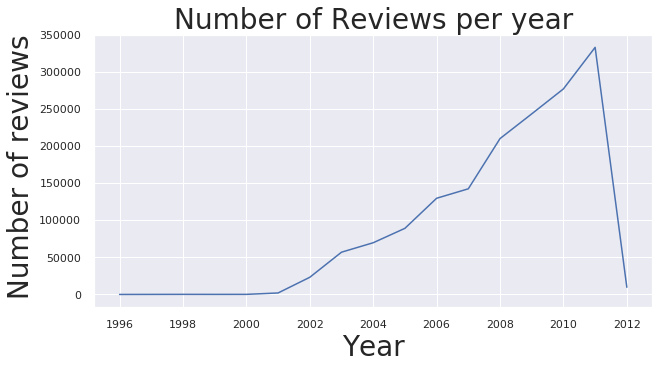

In [4]:
sns.set()

group_by_date = beersDf[[ 'review_time' ]].groupby(beersDf[ 'review_time' ].dt.year).agg( [ 'count' ] )
plt.figure( figsize = ( 10, 5 ))
plt.plot( group_by_date )
plt.xlabel( 'Year', fontsize=28 )
plt.ylabel( ' Number of reviews' , fontsize=28)
plt.title( 'Number of Reviews per year', fontsize=28 )
plt.show()

In [5]:
# I consider reviews from 2002 because for previous years there are no much information.
beersDf = beersDf.loc[ beersDf[ 'review_time' ].dt.year >= 2004]

## Unique data numbers

In [6]:
# Count of unique breweries => Integrity issues evidenced => Id is not considered for subsequent analysis
print( 'Unique breweries' )
print( 'By id:', beersDf[ 'brewery_id' ].nunique() )
print( 'By name:', beersDf[ 'brewery_name' ].nunique() )

Unique breweries
By id: 5644
By name: 5553


In [7]:
# Count of unique beers => Integrity issues evidenced => Id is not considered for subsequent analysis
print( 'Unique beers' )
print( 'By id:', beersDf[ 'beer_beerid' ].nunique() )
print( 'By name:', beersDf[ 'beer_name' ].nunique() )

Unique beers
By id: 63471
By name: 54842


Unique users: 33147


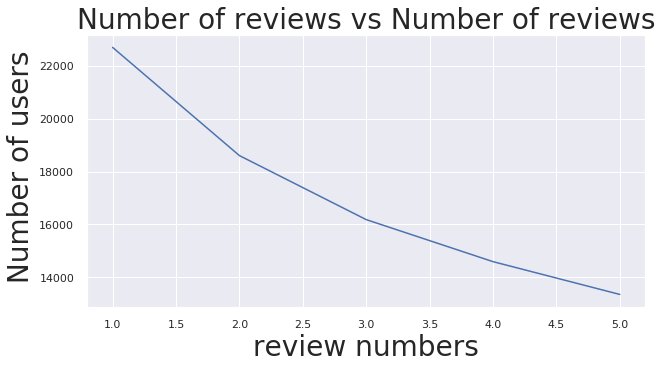

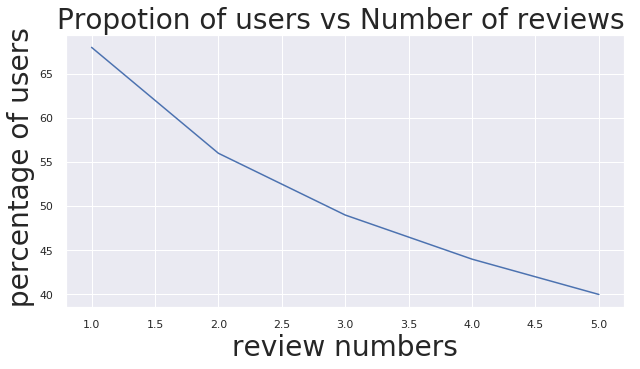

In [8]:
# Count of unique users
print( 'Unique users:', beersDf[ 'review_profilename' ].nunique() )
allUserNumbers = beersDf[ 'review_profilename' ].nunique()

def plotReviewNumbers():
    beerReviewNumbers = []
    beerReviewPercent = []
    
    for i in range(1, 6):
        
        numTemp = beersDf[ 'review_profilename' ].value_counts()[ beersDf[ 'review_profilename' ].value_counts() > i ].shape[0]
        
        beerReviewNumbers.append(numTemp)
        beerReviewPercent.append(round(numTemp/allUserNumbers, 2)*100)
    xRange = list(range(1, 6))
    
    plt.figure( figsize = ( 10, 5 ))
    plt.plot(xRange, beerReviewNumbers)

    plt.xlabel('review numbers', fontsize=28 )
    plt.ylabel(' Number of users' , fontsize=28)
    plt.title('Number of reviews vs Number of reviews', fontsize=28)
    plt.show()
    
    plt.figure( figsize = ( 10, 5 ))
    plt.plot(xRange, beerReviewPercent)

    plt.xlabel('review numbers', fontsize=28 )
    plt.ylabel(' percentage of users' , fontsize=28)
    plt.title('Propotion of users vs Number of reviews ', fontsize=28)
    plt.show()
    
        
plotReviewNumbers()


## Prediction overall rating based on surprise


In [9]:
groupedOverall = beersDf[['review_profilename', 'beer_beerid',  'review_overall' ]].drop_duplicates()



### using SVD Matrix decomposition

In [10]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
# Load the movielens-100k dataset (download it if needed),
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(beersDf[ ['review_profilename', 'beer_beerid',  'review_overall' ] ].drop_duplicates(), reader)
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)
# We'll use the famous SVD algorithm.


### prediction all testset as avearage[](http://)

In [11]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)
#     return sum(differences) / len(differences)

def predictAsAverage():
    testPrediction = [trainset.global_mean]*len(testset)
    testGroundTrue = []
    for element in testset:
        testGroundTrue.append(element[2])
    
    print(testPrediction[:10])
    print(testGroundTrue[:10])
    print("mse of prediction as average is ", MSE(testPrediction, testGroundTrue))
    
predictAsAverage()
    

[3.8181978730995043, 3.8181978730995043, 3.8181978730995043, 3.8181978730995043, 3.8181978730995043, 3.8181978730995043, 3.8181978730995043, 3.8181978730995043, 3.8181978730995043, 3.8181978730995043]
[3.5, 3.0, 4.0, 4.0, 4.5, 3.5, 3.0, 4.5, 4.5, 3.0]
mse of prediction as average is  0.51329726590435


In [12]:

# from surprise import KNNBaseline

# def KNNBase():

#     bsl_options = {'reg': 0,
#                 'method': 'sgd',
#                'learning_rate': .0005,
#                'n_epochs': 10
#                }
    
#     algo = KNNBaseline(bsl_options=bsl_options)
#     algo.fit(trainset)
#     predictions = algo.test(testset)
#     # Then compute RMSE
#     print(accuracy.rmse(predictions)**2)
    
# KNNBase()


In [13]:

from surprise import NormalPredictor

def normalPred():

    algo = NormalPredictor()
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Then compute RMSE
    print(accuracy.rmse(predictions)**2)
    
normalPred()


RMSE: 0.9912
0.9825732176257047


> ### using BaselineOnly

In [14]:
from surprise import BaselineOnly

def baselineOnlyNoReg():
    print('Using SGD')
    bsl_options = {'reg': 0,
                    'method': 'sgd',
                   'learning_rate': .0005,
                   'n_epochs': 10
                   }

    algo = BaselineOnly(bsl_options=bsl_options)

    algo.fit(trainset)
    predictions = algo.test(testset)

    # Then compute RMSE
    print(accuracy.rmse(predictions)**2)

baselineOnlyNoReg()


Using SGD
Estimating biases using sgd...
RMSE: 0.6348
0.40292763311744434


In [15]:
from surprise import BaselineOnly

def baselineOnlyALS():
    
    print('Using ALS')
    bsl_options = {'method': 'als',
                   'n_epochs': 20,
                   'reg_u': 12, #12
                   'reg_i': 8  #8
                   }

    algo = BaselineOnly(bsl_options=bsl_options)
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Then compute RMSE
    print(accuracy.rmse(predictions)**2)
    
baselineOnlyALS()


Using ALS
Estimating biases using als...
RMSE: 0.6052
0.36629444732397604


In [16]:
def baselineOnlySGD():
    print('Using SGD')
    bsl_options = {'reg': 0.02, # 0.02
                    'method': 'sgd',
                   'learning_rate': .0005,
                   'n_epochs': 20
                   }

    algo = BaselineOnly(bsl_options=bsl_options)

    algo.fit(trainset)
    predictions = algo.test(testset)

    # Then compute RMSE
    print(accuracy.rmse(predictions)**2)

baselineOnlySGD()


Using SGD
Estimating biases using sgd...
RMSE: 0.6243
0.3897445636839929


### using NMF

In [17]:
from surprise import NMF
def NMF_():
    
    algo = NMF(biased = True)
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Then compute RMSE
    print(accuracy.rmse(predictions)**2)
    
NMF_()


RMSE: 0.9191
0.8447254059472431


### using SVD

In [18]:
from surprise import SVD
def SVD_():
    algo = SVD()
    # Train the algorithm on the trainset, and predict ratings for the testset
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Then compute RMSE
    print(accuracy.rmse(predictions)**2)
    
SVD_()


RMSE: 0.6088
0.37068546667413255


## plot reviews distribution

In [19]:
# A beer subset removing review information is created 
groupedBDF = beersDf[ [ 'beer_name', 'brewery_name', 'beer_style', 'beer_abv' ] ].drop_duplicates()

In [20]:
# Count of unique beers in grouped dataset => Integrity issues evidenced with respect to previous analysis => For beer identification, I will use these 4 keys
groupedBDF.shape

(63288, 4)

In [21]:
# Count of beers with the same name but different brewery, style or AVB%
groupedBDF.loc[ groupedBDF.duplicated( subset = [ 'beer_name' ], keep = False ) ].sort_values( by = 'beer_name'  ).shape

(10930, 4)

In [22]:
# Beers by brewery
groupedBDF[ 'brewery_name' ].value_counts( dropna = False ).head()

Rock Bottom Restaurant & Brewery      824
John Harvard's Brewery & Ale House    362
Goose Island Beer Co.                 359
Iron Hill Brewery & Restaurant        315
Minneapolis Town Hall Brewery         299
Name: brewery_name, dtype: int64

In [23]:
# Beers by style
groupedBDF[ 'beer_style' ].value_counts( dropna = False ).head()

American IPA                3510
American Pale Ale (APA)     3155
American Amber / Red Ale    2394
American Porter             2081
Fruit / Vegetable Beer      1732
Name: beer_style, dtype: int64

### correlation map

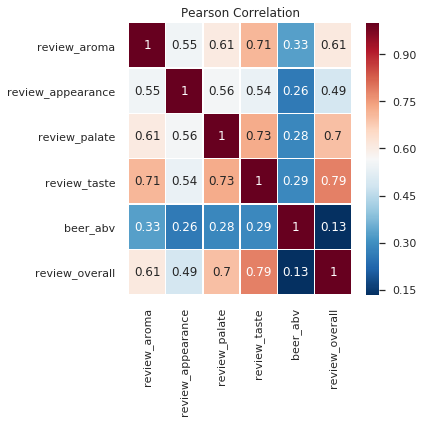

In [24]:
# # Pearson correlation
# sns.heatmap( beersDf[ ['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv', 'review_overall'] ].corr(), center = 0,  vmin = -1, vmax = 1 )

# plt.title( 'Pearson Correlation' )

import seaborn as sb
pearsoncorr = beersDf[['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv', 'review_overall']].corr(method='pearson')

plt.figure( figsize = ( 5, 5 ))
plt.title( 'Pearson Correlation' )

sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

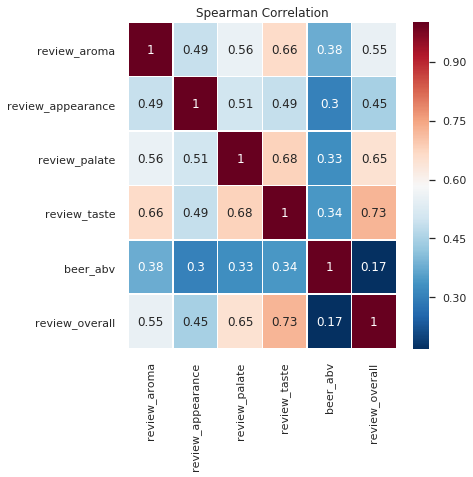

In [25]:
# # Spearman correlation
# sns.heatmap( beersDf[ [ 'review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv' ] ].corr( method = 'spearman' ), center = 0,  vmin = -1, vmax = 1 )
# plt.title( 'Spearman Correlation' )


pearsoncorr = beersDf[['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv', 'review_overall']].corr(method='spearman')

plt.figure( figsize = ( 6, 6 ))
plt.title('Spearman Correlation')
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)


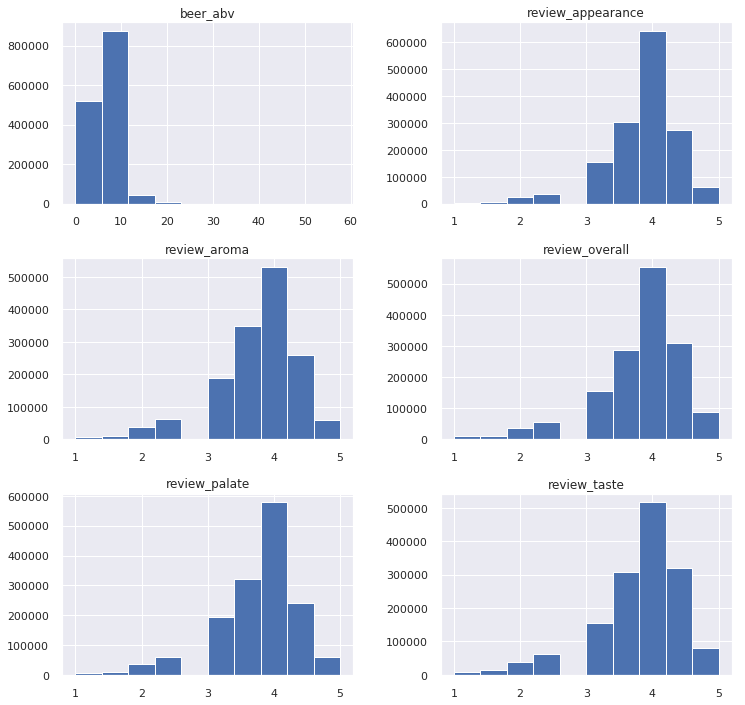

In [26]:
cm = plt.cm.get_cmap( 'tab10' )

dftemp = beersDf[['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv', 'review_overall']]
dftemp.hist(figsize = (12, 12))
plt.show()


3.8193023033178255
3.7422705291528
3.846389190641001
3.7493451572885657
3.7979644031490953


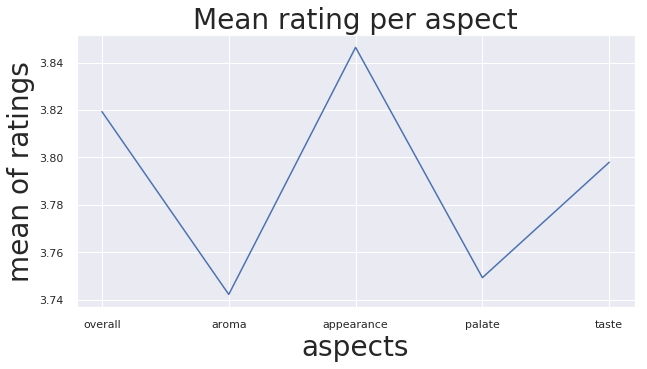

In [27]:
print(beersDf[ 'review_overall' ].mean())
print(beersDf[ 'review_aroma' ].mean())
print(beersDf[ 'review_appearance' ].mean())
print(beersDf[ 'review_palate' ].mean())
print( beersDf[ 'review_taste' ].mean())

meanRatingList = []
meanRatingList.append(beersDf[ 'review_overall' ].mean())
meanRatingList.append(beersDf[ 'review_aroma' ].mean())
meanRatingList.append(beersDf[ 'review_appearance' ].mean())
meanRatingList.append(beersDf[ 'review_palate' ].mean())
meanRatingList.append(beersDf[ 'review_taste' ].mean())

xRange = ['overall', 'aroma', 'appearance', 'palate', 'taste']

plt.figure( figsize = ( 10, 5 ))
plt.plot(xRange, meanRatingList)

plt.xlabel('aspects', fontsize=28 )
plt.ylabel('mean of ratings' , fontsize=28)
plt.title('Mean rating per aspect', fontsize=28)
plt.show()


In [28]:
# An new meassure is created by averaging review by factor
beersDf[ 'review_average' ] = round( ( ( beersDf[ 'review_overall' ] + beersDf[ 'review_aroma' ] + beersDf[ 'review_appearance' ] + beersDf[ 'review_palate' ] + beersDf[ 'review_taste' ] ) / 5 ) * 2 ) / 2

In [29]:
# # Groupping by different review factors for visualization purposes
# group_by_review_overall = beersDf[ 'review_overall' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_overall' : 'overall' } ).sort_values( by = 'review' )
# group_by_review_aroma = beersDf[ 'review_aroma' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_aroma' : 'aroma' } ).sort_values( by = 'review' )
# group_by_review_appearance = beersDf[ 'review_appearance' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_appearance' : 'appearance' } ).sort_values( by = 'review' )
# group_by_review_palate = beersDf[ 'review_palate' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_palate' : 'palate' } ).sort_values( by = 'review' )
# group_by_review_taste = beersDf[ 'review_taste' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_taste' : 'taste' } ).sort_values( by = 'review' )
# group_by_review_average = beersDf[ 'review_average' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_average' : 'average' } ).sort_values( by = 'review' )

# group_by_review_overall[ 'review' ] = group_by_review_overall[ 'review' ].astype( str )
# group_by_review_aroma[ 'review' ] = group_by_review_aroma[ 'review' ].astype( str )
# group_by_review_appearance[ 'review' ] = group_by_review_appearance[ 'review' ].astype( str )
# group_by_review_palate[ 'review' ] = group_by_review_palate[ 'review' ].astype( str )
# group_by_review_taste[ 'review' ] = group_by_review_taste[ 'review' ].astype( str )
# group_by_review_average[ 'review' ] = group_by_review_average[ 'review' ].astype( str )

# group_by_review = group_by_review_overall.merge( group_by_review_aroma, how = 'outer', on = [ 'review' ] )
# group_by_review = group_by_review.merge( group_by_review_appearance, how = 'outer', on = [ 'review' ] )
# group_by_review = group_by_review.merge( group_by_review_palate, how = 'outer', on = [ 'review' ] )
# group_by_review = group_by_review.merge( group_by_review_taste, how = 'outer', on = [ 'review' ] )
# group_by_review = group_by_review.merge( group_by_review_average, how = 'outer', on = [ 'review' ] )
# group_by_review = group_by_review.fillna( 0 )


In [30]:
# cm = plt.cm.get_cmap( 'tab10' ).

# f, ( ( ax1, ax2, ax3 ), ( ax4, ax5, ax6 ) ) = plt.subplots( 2, 3, sharex = 'col', sharey = 'row', figsize = ( 17, 10 ) )
# ax1.barh( group_by_review[ 'review' ], group_by_review[ 'overall' ], color = cm )
# ax1.set_title( 'Review Overall' )
# ax2.barh( group_by_review[ 'review' ], group_by_review[ 'aroma' ], color = cm )
# ax2.set_title( 'Review Aroma' )
# ax3.barh( group_by_review[ 'review' ], group_by_review[ 'appearance' ], color = cm )
# ax3.set_title( 'Review Appearance' )
# ax4.barh( group_by_review[ 'review' ], group_by_review[ 'palate' ], color = cm )
# ax4.set_title( 'Review Palate' )
# ax5.barh( group_by_review[ 'review' ], group_by_review[ 'taste' ], color = cm )
# ax5.set_title( 'Review Taste' )
# ax6.barh( group_by_review[ 'review' ], group_by_review[ 'average' ], color = cm )
# ax6.set_title( 'Review Average' )
# f.suptitle( 'Distribution of Reviews by Ratings')
# group_by_review = group_by_review.sort_values('review', ascending=False)

# group_by_review.hist(figsize=(12,12))
# plt.show()


### shuffle data

In [31]:
import random
random.seed(5)

X = beersDf[['review_aroma', 'review_appearance', 'review_palate', 'review_taste']].values.tolist()
y = beersDf[ 'review_overall' ].tolist()
y = [int(i*2) for i in y]

# Shuffle the data
Xy = list(zip(X,y))
random.shuffle(Xy)

X = [d[0] for d in Xy]
y = [d[1] for d in Xy]

print(len(X))


1504178


### split data

In [32]:
# Defining the linear model
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

# X = beersDf[ [ 'review_aroma', 'review_appearance', 'review_palate', 'review_taste' ] ]
split = int(1e5)
Xtrain = X[:2*split]
ytrain = y[:2*split]
xtest = X[14*split:15*split]
ytest = y[14*split:15*split]

# Create an instance of Logistic Regression Classifier and fit the data.


## K-means (not working) 

In [33]:
from sklearn.cluster import KMeans
import numpy as np
def k_means():
    kmeans = KMeans(n_clusters=11, random_state=0).fit(Xtrain)
    y_km = kmeans.fit_predict(Xtrain)
    y_km = list(y_km)
    for i in range(1, 12):
        print(i, y_km.count(i))
    for i in range(11):
        print(i, ytrain.count(i))
# k_means()

## logistic regression 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C is  1e-06  and MSE is  0.5438075
C is  1e-05  and MSE is  0.511495


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C is  0.0001  and MSE is  0.3387925


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C is  0.001  and MSE is  0.2561225


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C is  0.01  and MSE is  0.24975


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C is  0.1  and MSE is  0.24506


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C is  1.0  and MSE is  0.242855


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C is  10.0  and MSE is  0.2492325


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C is  100.0  and MSE is  0.24452


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C is  1000.0  and MSE is  0.243605


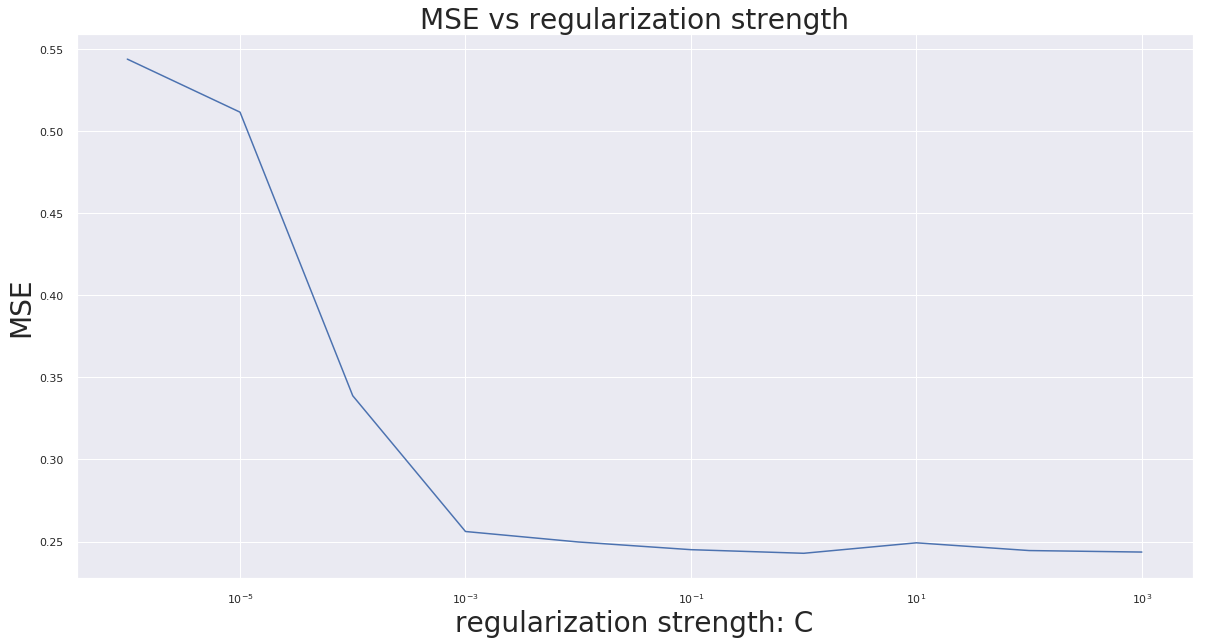

In [34]:
def logistRegre():
    mseList = []
    CList = []
    for i in range(10):
        
        ytestTemp = ytest
        C = math.pow(10, i-6)
        CList.append(C)
        logreg = LogisticRegression(C=C, solver='lbfgs', multi_class='multinomial')
        
        logreg.fit(X = Xtrain, y = ytrain)
        yPred = logreg.predict(xtest)

        yPred = [i/2 for i in yPred]
        ytestTemp = [i/2 for i in ytestTemp]
        mseTemp = MSE(yPred, ytestTemp)
        mseList.append(mseTemp)
        print("C is ", C, " and MSE is ", mseTemp)
    
    plt.figure( figsize = ( 20, 10 ))
    plt.plot(CList, mseList)
    plt.xscale('log')
    plt.xlabel('regularization strength: C', fontsize=28 )
    plt.ylabel('MSE' , fontsize=28)
    plt.title('MSE vs regularization strength', fontsize=28)
    plt.show()
    
    
logistRegre()


In [35]:
# Training and generating predictions for the model
linear_model = LinearRegression( normalize = True )
def linearRegre():
    ytestTemp = ytest
    linear_model.fit( X = Xtrain, y = ytrain )
    yPred = linear_model.predict(xtest)
    yPred = [i/2 for i in yPred]
    ytestTemp = [i/2 for i in ytestTemp]
    mseTemp = MSE(yPred, ytestTemp)
    print(mseTemp)
    print(linear_model.coef_)
    
linearRegre()


0.17696233054652838
[0.09279309 0.07438525 0.51936153 1.10237329]


In [36]:
# Coeffifients for each feature (aroma, appearance, palate, taste)


Similar to results by correlation, the coefficients contributing more information to the model are the corresponding to taste and aroma features.